## Лабораторная работа "Введение в ML"

В этой лабораторной вы:

- познакомитесь с базовыми библиотеками для работы с табличными данными — `numpy` и `pandas`
- поближе посмотрите на простейшие задачи машинного обучения: классификацию и регрессию
- попробуете несколько метрик и поймёте, почему выбор метрики это важно
- обучите несколько простых моделей
- увидите связь между сложностью модели и переобучением
- убедитесь, что без данных всё тлен

Загрузка самых базовых библиотек:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

### [NumPy](https://numpy.org/doc/stable/user/index.html)

С 1995 numeric, с 2006 NumPy — «Numerical Python extensions» или просто «NumPy»

Возможности библиотеки NumPy:
* работать с многомерными массивами (таблицами)
* быстро вычислять математические функций на многомерных массивах

Ядро пакета NumPy — объект [ndarray](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html)

**Важные отличия** между NumPy arrays и Python sequences:
* NumPy array имеет фиксированную длину, которая определяется в момент его создания (в отличие от Python lists, которые могут расти динамически)
* Элементы в NumPy array должны быть одного типа
* Можно выполнять операции непосредственно над NumPy arrays

**Скорость** NumPy достигается с помощью:
* реализации на C
* векторизации и броадкастинга (broadcasting). Например, произведение массивов совместимых форм.

Теперь давайте разберёмся подробнее и сделаем что-нибудь приятное и полезное в `numpy`!

### Индексация

В NumPy работает привычная индексация Python, ура! Включая использование отрицательных индексов и срезов (slices)

<div class="alert alert-info">
<b>Замечание 1:</b> Индексы и срезы в многомерных массивах не нужно разделять квадратными скобками,
т.е. вместо <b>matrix[i][j]</b> нужно использовать <b>matrix[i, j]</b>. Первое тоже работает, но сначала выдаёт строку i, потом элемент j в ней.
</div>

<div class="alert alert-danger">
<b>Замечание 2:</b> Срезы в NumPy создают view, а не копии, как в случае срезов встроенных последовательностей Python (string, tuple and list).
</div>

In [ ]:
ones_matrix = np.ones((5, 5))
ones_submatrix_view = ones_matrix[::2,::2] # creates a view, not copy
ones_matrix[::2,::2] = np.zeros((3, 3))
ones_submatrix_view

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

### Ссылка на Яндекс.Контест

Решения и ответы в задачах, расположенных ниже, загружайте в контест на автоматическую проверку:
https://new.contest.yandex.ru/60376/start


**1.** Реализуйте функцию, принимающую на вход два одномерных массива `first_array` и `second_array` и возвращающую матрицу, в которой первый массив соответствует первому столбцу матрицы, второй — второму.

Вероятно первое, что приходит вам на ум, это конкатенация и транспонирование:

In [ ]:
def construct_matrix(first_array, second_array):
    """
    Construct matrix from pair of arrays
    :param first_array: first array
    :param second_array: second array
    :return: constructed matrix
    """
    n = len(first_array)
    return np.hstack([first_array.reshape(n, 1), second_array.reshape(n, 1)])

In [ ]:
construct_matrix(np.array([1,2]),np.array([3,4]))

array([[1, 3],
       [2, 4]])

(в скобках заметим, что конкатенировать можно vertically, horizontally, depth wise методами vstack, hstack, dstack по трём осям (0, 1 и 2, соотвественно), либо в общем случае `np.concatenate` — поиграйтесь ниже с прекрасным примером четырёхмерной точки, чтобы точно всё для себя понять)

In [ ]:
p = np.arange(1).reshape([1, 1, 1, 1])
p

array([[[[0]]]])

In [ ]:
print("vstack: ", np.vstack((p, p)).shape)
print("hstack: ", np.hstack((p, p)).shape)
print("dstack: ", np.dstack((p, p)).shape)

vstack:  (2, 1, 1, 1)
hstack:  (1, 2, 1, 1)
dstack:  (1, 1, 2, 1)


In [ ]:
np.concatenate((p, p), axis=3).shape

(1, 1, 1, 2)

Но, поскольку операция транспонирования [делает массив non-contiguous](https://numpy.org/doc/stable/user/basics.copies.html#other-operations), мы в этой задаче **запретим** ей пользоваться и порекомедуем воспользоваться, например, методом [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).

**2.** Реализуйте функцию, принимающую на вход массив целых неотрицательных чисел `nums` и возвращающую самый частый элемент массива.

In [ ]:
import numpy as np
from scipy import stats
def most_frequent(nums):
    return stats.mode(nums).mode

### Переходим к работе с данными

Прежде всего, загрузим данные и сделаем из них красивые pandas-таблички. Они взяты из параллели RecSys соревнования https://yandex.ru/cup/ml/. Но мы будем иметь дело не со всеми данными, а только с их частью. Данные у нас будут про заведения общественного питания (больше бюрократический терминологии!)

Файлы с данными можно найти [здесь](https://disk.yandex.ru/d/YWvCNRQMb7QSQA).

Задачей будет **предсказание среднего чека** (average_bill) по некоторым другим свойствам заведения.

In [ ]:
data = pd.read_csv('organisations.csv')
features = pd.read_csv('features.csv')
rubrics = pd.read_csv('rubrics.csv')

В основном мы будем работать с табличкой `data`; остальное вам может пригодиться, если вы захотите знать, какое содержание стоит за кодами признаков.

## Изучение данных

Посмотрите на данные. В этом вам поможет метод ``head`` pandas-таблички.

In [ ]:
data.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
0,15903868628669802651,msk,1500.0,4.270968,30776 30774,3501685156 3501779478 20422 3502045016 3502045...
1,16076540698036998306,msk,500.0,4.375000,30771,1509 1082283206 273469383 10462 11617 35017794...
2,8129364761615040323,msk,500.0,4.000000,31495,10462 11177 11617 11629 1416 1018 11704 11867 ...
3,15262729117594253452,msk,500.0,4.538813,30776 30770,3501618484 2020795524 11629 11617 1018 11704 2...
4,13418544315327784420,msk,500.0,4.409091,31495,11617 10462 11177 1416 11867 3501744275 20282 ...


In [ ]:
data.shape

(68339, 6)

In [ ]:
rubrics.head()

,rubric_id,rubric_name
0,30519,"Булочная, пекарня"
1,30770,"Бар, паб"
2,30771,Быстрое питание
3,30774,Кафе
4,30775,Пиццерия


Полезно посмотреть внимательнее на то, с какими признаками нам предстоит работать.

* **org_id** вам не понадобится;
* **city** - город, в котором находится заведение (``msk`` или ``spb``);
* **average_bill** - средний чек в заведении - он будет нашим таргетом;
* **rating** - рейтинг заведения;
* **rubrics_id** - тип заведения (или несколько типов). Соответствие кодов каким-то человекочитаемым типам живёт в табличке ``rubrics``
* **features_id** - набор неких фичей заведения. Соответствие кодов каким-то человекочитаемым типам живёт в табличке ``features``

Обратите внимание, что **rubrics_id** и **features_id** - это не списки, а разделённые пробелами строки. Когда вам захочется работать с отдельными фичами из мешка фичей для данного заведения, вам придётся всё-таки превратить их в списки (здесь поможет метод `split` для строк).

Чтобы быстро восстанавливать по рубрикам и фичам их нормальные названия, сделайте словари вида ``код_фичи:название_фичи``

In [ ]:
rubric_dict = dict()
for val in rubrics.values:
    rubric_dict[val[0]] = val[1]

In [ ]:
features_dict = dict()
for val in features.values:
    features_dict[val[0]] = val[1]

Посмотрим, какими бывают типы заведений:

In [ ]:
rubric_dict

{30519: 'Булочная, пекарня',
 30770: 'Бар, паб',
 30771: 'Быстрое питание',
 30774: 'Кафе',
 30775: 'Пиццерия',
 30776: 'Ресторан',
 30777: 'Столовая',
 31286: 'Спортбар',
 31350: 'Кондитерская',
 31375: 'Суши-бар',
 31401: 'Кальян-бар',
 31495: 'Кофейня',
 3108292683: 'Бар безалкогольных напитков',
 3501514558: 'Фудкорт',
 3501750896: 'Кофе с собой'}

Мы что-то поняли про признаки, которыми нам предстоит пользоваться. Теперь время посмотреть на таргет. Вооружившись функциями ``hist`` и ``scatter`` из библиотеки ``matplotlib``, а также методом ``isna`` для pandas-таблиц разберитесь, какие значения принимают таргеты, есть ли там там выбросы, пропуски или ещё какие-то проблемы.

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    <ol>
      <li>Среди таргетов довольно много пропусков;</li>
      <li>Все таргеты - это числа, кратные 500;</li>
      <li>Есть какие-то адские значения, превышающие 100 000 (видимо, выбросы);</li>
      <li>В целом, число ресторанов с данным средним чеком быстро падает с ростом среднего чека. Для средних чеков, больших 2500, заведений уже совсем мало. Примерно у 2/3 заведений средний чек 500.</li>
    </ol>
</details>

In [ ]:
data['average_bill'] = data['average_bill'].dropna().astype(int)

In [ ]:
missing_values = data['average_bill'].isna().sum()
print(f"Количество пропусков в 'average_bill': {missing_values}")

Количество пропусков в 'average_bill': 35561


In [ ]:
sum(data['average_bill'] >= 100000)

9

In [ ]:
unique_values = data['average_bill'].unique()
formatted_values = [f'{value:.0f}' for value in unique_values if not np.isnan(value)]
unique_count = data['average_bill'].nunique()
print(*formatted_values)
print(f"Количество уникальных значений: {unique_count}")

1500 500 1000 2000 3500 2500 3000 4500 4000 62500 7500 5000 6000 10000 15000 100000 21000 7000 13500 29500 9000 45500 43000 22000 7502000 24500 500000 40000 8000 5500 23000 17500 36500 76000 41500 246000 18500 117000 12500 6500 30000 203500 19000 49500 57500 9500 8500 26500 152000 20000 24000 68000 65500 16500 46000 88000 31500 50500 60000 12000 25500 250000 101500
Количество уникальных значений: 63


In [ ]:
from collections import Counter
counter = Counter(data['average_bill'].dropna())
counter

Counter({1500.0: 2696,
         500.0: 22329,
         1000.0: 5482,
         2000.0: 1184,
         3500.0: 140,
         2500.0: 445,
         3000.0: 242,
         4500.0: 38,
         4000.0: 67,
         62500.0: 1,
         7500.0: 9,
         5000.0: 31,
         6000.0: 16,
         10000.0: 7,
         15000.0: 3,
         100000.0: 1,
         21000.0: 2,
         7000.0: 7,
         13500.0: 2,
         29500.0: 3,
         9000.0: 7,
         45500.0: 1,
         43000.0: 2,
         22000.0: 1,
         7502000.0: 1,
         24500.0: 2,
         500000.0: 1,
         40000.0: 1,
         8000.0: 5,
         5500.0: 9,
         23000.0: 3,
         17500.0: 1,
         36500.0: 1,
         76000.0: 1,
         41500.0: 2,
         246000.0: 1,
         18500.0: 1,
         117000.0: 1,
         12500.0: 3,
         6500.0: 4,
         30000.0: 1,
         203500.0: 1,
         19000.0: 3,
         49500.0: 1,
         57500.0: 1,
         9500.0: 1,
         8500.0: 1,
   

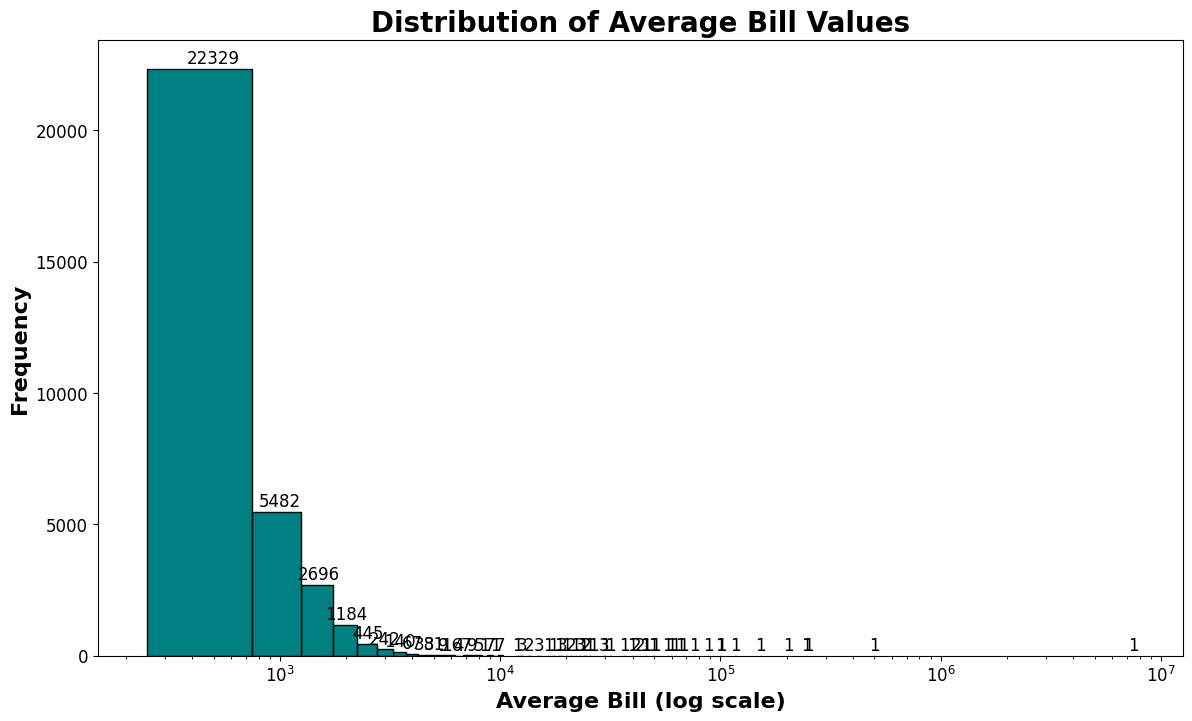

In [ ]:
values = list(counter.keys())
frequencies = list(counter.values())

plt.figure(figsize=(14, 8))
bars = plt.bar(values, frequencies, color='teal', edgecolor='black', width=500)

plt.xscale('log')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom', fontsize=12)

plt.title('Distribution of Average Bill Values', fontsize=20, weight='bold')
plt.xlabel('Average Bill (log scale)', fontsize=16, weight='bold')
plt.ylabel('Frequency', fontsize=16, weight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

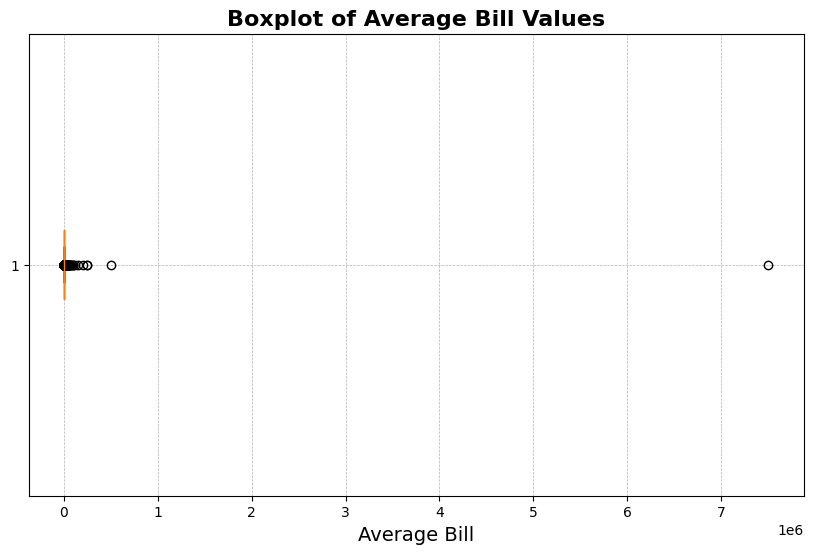

In [ ]:
dt = []
for value, freq in counter.items():
    dt.extend([value] * freq)

plt.figure(figsize=(10, 6))
plt.boxplot(dt, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))

plt.title('Boxplot of Average Bill Values', fontsize=16, weight='bold')
plt.xlabel('Average Bill', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)

plt.show()

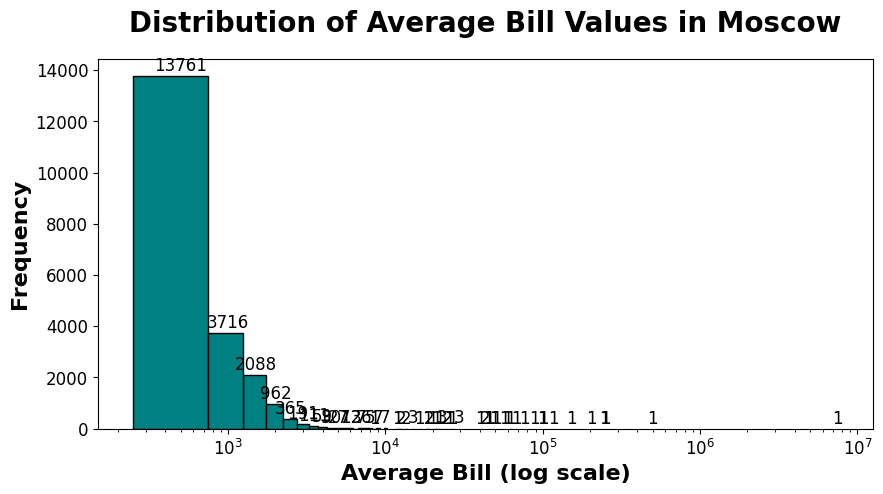

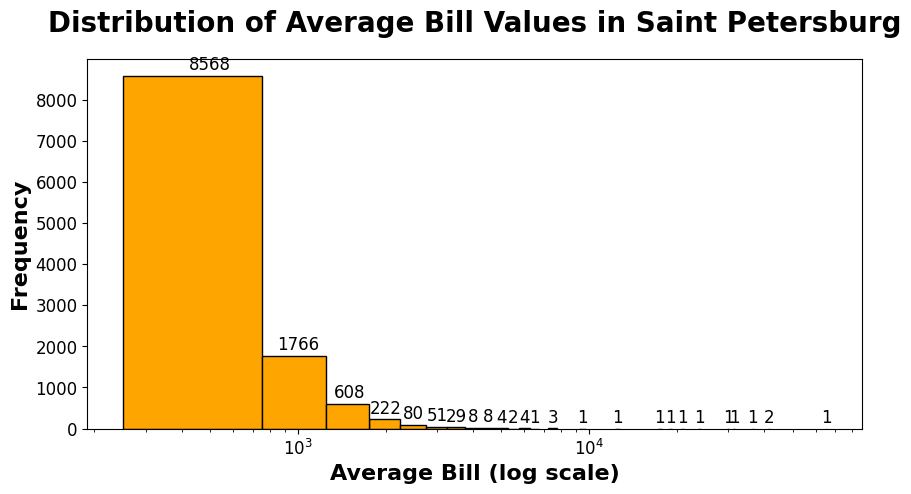

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

cities = {'msk': 'Moscow', 'spb': 'Saint Petersburg'}
colors = {'msk': 'teal', 'spb': 'orange'}

for city, city_name in cities.items():
    counter = Counter(data[data['city'] == city]['average_bill'].dropna())

    values = list(counter.keys())
    frequencies = list(counter.values())

    plt.figure(figsize=(10, 5))
    bars = plt.bar(values, frequencies, color=colors[city], edgecolor='black', width=500)
    plt.xscale('log')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', va='bottom', fontsize=12)

    plt.title(f'Distribution of Average Bill Values in {city_name}', fontsize=20, weight='bold', y=1.05)
    plt.xlabel('Average Bill (log scale)', fontsize=16, weight='bold')
    plt.ylabel('Frequency', fontsize=16, weight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.subplots_adjust(top=0.85)

    plt.show()

**Базовая очистка данных**

Раз есть треш, давайте чистить данные.

С пропусками можно бороться по-разному (даже и с пропусками в таргете), но пока мы сделаем самую простую вещь: дропнем все заведения, для которых мы не знаем средний чек.

Уберите из них все заведения, у которых средний чек неизвестен или превышает 2500. Пока есть опасение, что их слишком мало, чтобы мы смогли обучить на них что-нибудь.

**3. Введите в Контест количество заведений, которое у вас получилось после очистки**.

Дальше мы будем работать с очищенными данными.

In [ ]:
data = data[(data['average_bill'].notna()) & (data['average_bill'] <= 2500.)]

In [ ]:
data.shape

(32136, 6)

**4. Посчитайте и введите в Контест разность между средними арифметическими average_bill в кафе Москвы и Санкт-Петербурга. Округлите ответ до целого.**

&nbsp;

<details>
  <summary>Небольшая подсказка</summary>
  Примените часто используемый метод groupby.
</details>

In [ ]:
def check_rubric(x, rubric='30774'):
    return rubric in x

In [ ]:
rub = '30774'
average_city = round(data[data['rubrics_id'].apply(lambda x: check_rubric(x, rubric=rub))].groupby('city')['average_bill'].mean())
average_city.iloc[0] - average_city.iloc[1]

142.0

Давайте ещё немного поизучаем данные. Ответьте на вопросы:

1. Есть ли разница между средними чеками в Москве и Санкт-Петербурге?
2. Коррелирует ли средний чек с рейтингом?
3. Есть ли разница в среднем чеке между ресторанами и пабами (см. соответствующие типы из ``rubrics``)?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    <ol>
      <li>В целом, да. Вы могли бы сравнить средние (в Москве больше) или медианы (они равны, потому что уж больно много где средний чек 500). Этого, конечно, мало для того, чтобы сделать вывод. Нужно проверять какие-то статические критерии, которые изучаются в курсе по статистике. Не будем останавливаться на этом подробно. Поскольку данные совсем не нормальные, никакой t-тест не сработает; мы бы предложили использовать критерий Манна-Уитни (см. википедию и функцию mannwhitneyu из библиотеки scipy.stats).</li>
      <li>Какая-то корреляция между ними есть но уж больно неубедительная (рекомендуем построим на одном графике boxplot рейтинга по каждому значению среднего чека для визуализации). Конечно, дна становится меньше с ростом среднего чека, но, видимо, в предсказании это особо не используешь;</li>
      <li>Несомненно, в ресторанах средний чек выше. Это и невооружённым глазом видно, и с помощью критерия Манна-Уитни можно проверить.</li>
    </ol>
</details>

In [ ]:
data.groupby('city')['average_bill'].mean()

,average_bill
city,
msk,792.887230
spb,676.449662


In [ ]:
data["average_bill"].corr(data["rating"])

0.09026290021639105

In [ ]:
rest_pub = {
    'Ресторан': '30776',
    'Паб': '30770'
}
for key, val in rest_pub.items():
    print(key, 'average bill', round(data[data['rubrics_id'].apply(lambda x: check_rubric(x, rubric=val))]['average_bill'].mean()))

Ресторан average bill 995
Паб average bill 814


## Формулируем задачу

Прежде, чем решать задачу, её надо сформулировать.

**Вопрос первый**: это классификация или регрессия? Подумайте над этим.

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    Ответ не столь однозначен, как хотелось бы. С одной стороны, таргет принимает всего четыре значения, и потому это может быть классификацией с 4 классами. С другой стороны, таргеты - это не абстрактные "треугольник", "круг", "квадрат", а вещественные числа, и когда мы вместо 500 предсказываем 2500, это явно хуже, чем вместо 1500 предсказать 2000. В целом, задачу можно решать и так, и так; мы будем смотреть на метрики обеих задач.
</details>

**Вопрос второй**: какие метрики мы будем использовать для оценки качества решения? Какие метрики вы предложили бы для этой задачи как для задачи классификации? А для этой задачи, как для задачи регрессии?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    
    Начнём с классификации. Метрика accuracy не очень хороша из-за несбалансированности классов. Действительно, классификатор, который всегда говорит 500, будет иметь accuracy примерно 0.66, хотя это никак не отражает практическую ценность модели. Как мы увидим, самая большая проблема будет заключаться в том, чтобы научиться выделять заведения с большими чеками, а их меньше всего и в accuracy они вносят самый маленький вклад. Есть разные способы с этим бороться, один -- использовать sklearn.metrics.balanced_accuracy_score. Его идея, грубо говоря, в том, чтобы по каждому классу найти, какая доля объектов этого класса правильно классифицирована, а потом эти доли усреднить. Тогда у бессмысленного классификатора, который всем ставит 500, будет скор 1/5 (ведь классов 5), а чтобы получить прежние 2/3, нужно будет научиться в каждом классе правильно ставить хотя бы 2/3 меток.    
    
    Теперь что касается регрессии. Основых метрики две - MSE и MAE. Из первой стоит извлекать корень, чтобы получать интерпретируемые человеком значения, а вторая менее агрессивна к выбросам (впрочем, выбросов тут уже нет, мы их все выкинули). Без дополнительной информации не очень понятно, какую выбирать, можно брать любую. А выбирать надо: ведь даже банальные модели "предсказывай всегда среднее" и "предсказывай всегда медиану" будут по-разному ранжироваться этими метриками.
    
</details>

**Вопрос третий**: а не взять ли нам какую-нибудь более экзотическую метрику? Например, MAPE (определение в учебнике в главе про оценку качества моделей). А как вам такое соображение: допустим, заказчик говорит, что пользователи будут расстраиваться, только если мы завысили средний чек - так давайте поправим MSE или MAE, обнуляя те слагаемые, для которых предсказанный таргет меньше истинного. Вот это хорошая метрика или нет?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    
    Что касается MAPE, у нас нет тех проблем, с которой она борется. Вот если бы у нас были средние чеки от 500 до миллиона, мы бы столкнулись с ситуацией, что большие ошибки для больших чеков доминировали бы в сумме для MSE и MAE (500 вместо 1000 меркнет по сравнению с 500к вместо миллиона). Говоря поэтически, мы бы оптимизировали модель для миллионеров, забыв про простых трудяг. И было бы логично перейти от парадигмы "ошибаемся на 500 рублей" к парадигме "ошибаемся на 50%". Но у нас все таргеты примерно одного порядка, MAPE нам особо ни к чему.
    
    Вторая метрика коварна тем, что её можно "накрутить" безо всякой пользы для дела. А именно, модель, которая всегда предсказывает средний чек в миллион, была бы идеальна. Но все бы расстраивались и не ходили есть. Другое дело, что можно ввести разные веса для ошибок в большую и в меньшую сторону, но опять же - пока нет показаний к тому, что это нужно.
    
</details>

## Применяем ML

Теперь время разбить данные на обучающую и тестовую выборку. Делается это с помощью функции ``train_test_split`` из пакета ``sklearn``. При этом очень важно сделать две вещи:

* Зафиксировать ``random_state=42`` (да, именно этот, а то ваши модели могут не зайти в Контест), чтобы всё, что мы делаем, было воспроизводимо (иначе от перезапуска к перезапуску числа могут меняться, и мы не будем понимать, из-за чего это происходит).
* Сделать стратификацию по таргету. В противном случае у нас в трейне и тесте могут оказаться разные пропорции классов (обычно особенно страдают мало представленные классы), что неутешительно скажется на результате.

**Обратите внимание**, что если вы побьёте выборку на train и test по-другому, ваши результаты могут не зайти в контест.

In [ ]:
clean_data = data.copy()

In [ ]:
clean_data_train, clean_data_test = train_test_split(
    clean_data, stratify=clean_data['average_bill'], test_size=0.33, random_state=42)

Теперь нам нужен **бейзлайн** - очень простая модель, с которой мы в дальнейшем будем сравниваться.

Поскольку мы ещё не знаем никаких умных классов моделей, все модели мы будем писать руками. А именно, мы напишем две простых модели на основе ``sklearn.baseRegressorMixin`` и ``sklearn.base.ClassifierMixin`` (посмотрите примеры в документации sklearn и сделайте так же):

* Модель для задачи регрессии, которая для всех заведений предсказывает одно число — среднее значение среднего чека;
* Модель для задачи классификации, которая для всех заведений предсказывает один класс — самый частый класс (ироничным образом он в данном случае совпадает с медианой).

**Важно!** Мы будем много раз повторять вам мантру о том, что **информация из тестовой выборки не должна протекать в процесс обучения**. Так вот, и среднее, и самый частый класс вы должны считать именно на обучающей выборке!

**5 и 6. Напишите эти две модели и сдайте в Контест**. В процессе проверки модели будут и обучаться, и предсказывать.

Заметим, что для этих моделей нам вообще не нужны какие-то "фичи"; мы работаем только с таргетом.

У каждой модели есть (как минимум) два метода: `fit` (обучает модель по фичам `X` и таргету `y`) `predict` (предсказывает по фичам `X`)

In [ ]:
from scipy.stats import mode

from sklearn.base import RegressorMixin

class MeanRegressor(RegressorMixin):
    def __init__(self):
      self.result = None

    def fit(self, X=None, y=None):
      self.result = y.mean()


    def predict(self, X=None):
        n = X.shape[0]
        return [self.result] * n


from sklearn.base import ClassifierMixin

class MostFrequentClassifier (ClassifierMixin):
    def __init__(self):
        self.most_frequent_class = None

    def fit(self, X=None, y=None):
        self.most_frequent_class = mode(np.array(y)).mode

    def predict(self, X=None):
        return [self.most_frequent_class] * len(X)

Обучим наши модели

In [ ]:
reg = MeanRegressor()
reg.fit(y=clean_data_train['average_bill'])

clf = MostFrequentClassifier()
clf.fit(y=clean_data_train['average_bill'])

In [ ]:
from sklearn.metrics import mean_squared_error, balanced_accuracy_score
np.sqrt(mean_squared_error(clean_data_test['average_bill'], reg.predict(clean_data_test))),\
balanced_accuracy_score(clean_data_test['average_bill'], clf.predict(clean_data_test)),\
np.sqrt(mean_squared_error(clean_data_test['average_bill'], clf.predict(clean_data_test)))

(448.7143889551622, 0.2, 514.7517402382093)

Обучите модели и оцените их качество на тестовой выборке. В качестве метрик возьмём RMSE (``np.sqrt`` от ``sklearn.metrics.mean_squared_error``) и ``sklearn.metrics.balanced_accuracy_score``.

Для регрессионной модели имеет смысл считать только RMSE (значения будут не кратны 500, точно мы угадывать не будем никогда), а вот для классификационной можно найти обе метрики. Сделайте это. Какая модель оказалась лучше по RMSE?

<details>
  <summary>Когда будете готовы, кликните сюда</summary>
    
  Казалось бы, регрессор никогда не угадывает, но он в каком-то смысле лучше классификатора - справедливо ли это? Возможно. Несуществующий пользователь модели вряд ли будет задавать вопросы "почему средний чек не кратен 500?" Ну, выдали около 800 - ок, понятно.
    
</details>

## Усложнение модели

Бейзлайны будут нашей отправной точкой. Строя дальнейшие модели, мы будем спрашивать себя: получилось ли лучше бейзлайна? Если нет или если не особо, то в чём смысл усложнения?

Начнём с использования фичи ``city``. Мы уже видели, что в разных городах и средние чеки разные. Легко проверить, что *медиана* средних чеков всё же одна и та же и в Москве, и в Санкт-Петербурге (ох уж этот вездесущий средний чек 500!), поэтому с классификатором мы ничего не сделаем. Но вот регрессор можно попробовать починить.

**7. Напишите регрессор, для каждого заведения предсказывающий среднее значение в том же городе (на обучающей выборке, конечно) и сдайте его в Контест**. Вам может помочь то, что булевы `pandas` и `numpy` столбцы можно умножать на численные — в такой ситуации False работает, как ноль, а True как единица.

In [ ]:
import pandas as pd
from sklearn.base import RegressorMixin
class CityMeanRegressor(RegressorMixin):
    def __init__(self):
      self.msk = None
      self.spb = None
    def fit(self, X=None, y=None):
        y = pd.Series(y)
        self.msk = y[X['city'] == 'msk'].mean()
        self.spb = y[X['city'] == 'spb'].mean()
    def predict(self, X=None):
        result = []
        for val in X['city']:
          result.append(self.msk if val == 'msk' else self.spb)
        return result

In [ ]:
reg_city = CityMeanRegressor()
reg_city.fit(clean_data_train.drop(columns='average_bill'), clean_data_train['average_bill'])

In [ ]:
np.sqrt(mean_squared_error(clean_data_test['average_bill'], reg_city.predict(clean_data_test)))

445.1063281403263

Обучите регрессор и сравните его по метрике RMSE с бейзлайнами. Получилось ли улучшить метрику?

Лучше стало, но, правда, не очень сильно. В этот момент очень важно не просто радовать руководителя приростом в третьем знаке, но и думать о том, что происходит.

Средний средний чек по Москве равен 793, в Санкт-Петербурге - 676, а в целом - 752 рубля. MSE, увы, не поможет вам ответить на вопрос, стало ли лучше пользователю, если вы ему вместо 752 рублей назвали 793. Здесь вскрывается весьма существенный порок MSE в этой задаче. Дело в том, что наш изначальный таргет делит заведения на некоторые "ценовые категории", и различие в средних чеках 500 и 1000 в самом деле существенно. Наверное, мы хотели бы как раз правильно предсказывать ценовые категории. Но MSE не очень помогает нам об этом судить. Дальше мы ещё подумаем, как это исправить.

В любом случае, несмотря на улучшение метрики, мы пока не можем судить, стало ли по жизни лучше от усложнения модели.

Поручинившись немного, возьмём на вооружение другую идею. Давайте использовать типы заведений!

Но с типами есть некоторая проблема: в столбце ``rubrics_id`` не всегда один идентификатор, часто их несколько, и всего комбинаций довольно много. Чтобы не возиться с малочисленными типами, давайте сольём их в один безликий ``other``.

Итак, добавьте в обучающие и тестовые данные столбец ``modified_rubrics``, в котором будет то же, что и в ``rubrics_id``, если соответствующая комбинация рубрик содержит хотя бы 100 заведений из обучающей (!) выборки, и строка ``other`` в противном случае.

Здесь вам поможет контейнер ``Counter`` из библиотеки ``collections``.

In [ ]:
counter = Counter(data['rubrics_id'])
filtered_counter = {key: value for key, value in counter.items() if value >= 100}

In [ ]:
def modified_rubrics_fun(x:str)->str:
    return x if x in filtered_counter else 'other'

In [ ]:
clean_data_train['modified_rubrics'] = clean_data_train['rubrics_id'].apply(modified_rubrics_fun)
clean_data_test['modified_rubrics'] = clean_data_test['rubrics_id'].apply(modified_rubrics_fun)

In [ ]:
clean_data_train['modified_rubrics']

,modified_rubrics
45769,30770
39061,30774 30776
59281,30776 30774
51225,other
29587,30770
...,...
64667,30771
47309,30771
26208,30775
48599,31495 30774


Теперь настало время написать могучий классификатор, который по заведению предсказывает медиану средних чеков среди тех в обучающей выборке, у которых с ним одинаковые `modified_rubrics` и город (вы спросите, почему медиану, а не самый частый -- спишем это на вдохновение; самый частый тоже можно брать - но медиана работает лучше).

**8. Напишите классификатор и сдайте в Контест**.

In [ ]:
import numpy as np
from scipy.stats import mode
from sklearn.base import ClassifierMixin
class RubricCityMedianClassifier(ClassifierMixin):
    def __init__(self):
      self.place = []
      self.msk_median_place = []
      self.spb_median_place = []
    def fit(self, X=None, y=None):
        self.place = list(np.unique(X['modified_rubrics'].values))
        for place in self.place:
          self.msk_median_place.append(y[(X['city'] == 'msk') & (X['modified_rubrics'] == place)].median())
          self.spb_median_place.append(y[(X['city'] == 'spb') & (X['modified_rubrics'] == place)].median())
    def predict(self, X=None):
        result = []
        for c, r in zip(X['city'], X['modified_rubrics']):
          if c == 'msk':
            result.append(self.msk_median_place[self.place.index(r)])
          else:
            result.append(self.spb_median_place[self.place.index(r)])
        return result

In [ ]:
clf_rub = RubricCityMedianClassifier()
clf_rub.fit(clean_data_train.drop(columns='average_bill'), clean_data_train['average_bill'])

In [ ]:
np.sqrt(mean_squared_error(clean_data_test['average_bill'], clf_rub.predict(clean_data_test))),\
balanced_accuracy_score(clean_data_test['average_bill'], clf_rub.predict(clean_data_test))

(391.83678731393195, 0.3073310992848548)

Сравните обученный классификатор по метрикам RMSE и balanced_accuracy_score с нашими бейзлайнами. Получилось ли улучшить?

Обратите внимание что рост accuracy по сравнению с бейзлайном при этом на порядок меньше:

accuracy_score

Predict most frequent:  0.6947666195190948

Predict by rubric and city:  0.7095709570957096

Для диагностики напечатайте для каждого класса тестовой выборки, сколько в нём объектов и скольким из них наш классификатор приписал правильный класс. Что вы видите?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    
  Вы, вероятно, видите то, что мы стали однозначно лучше по сравнению с бейзлайном детектировать средний чек 1000 и 1500 (хотя всё равно не очень хорошо + ценой ухудшения качества на среднем чеке 500), а вот чеки 2000 и 2500 нам ну никак не даются.
    
</details>

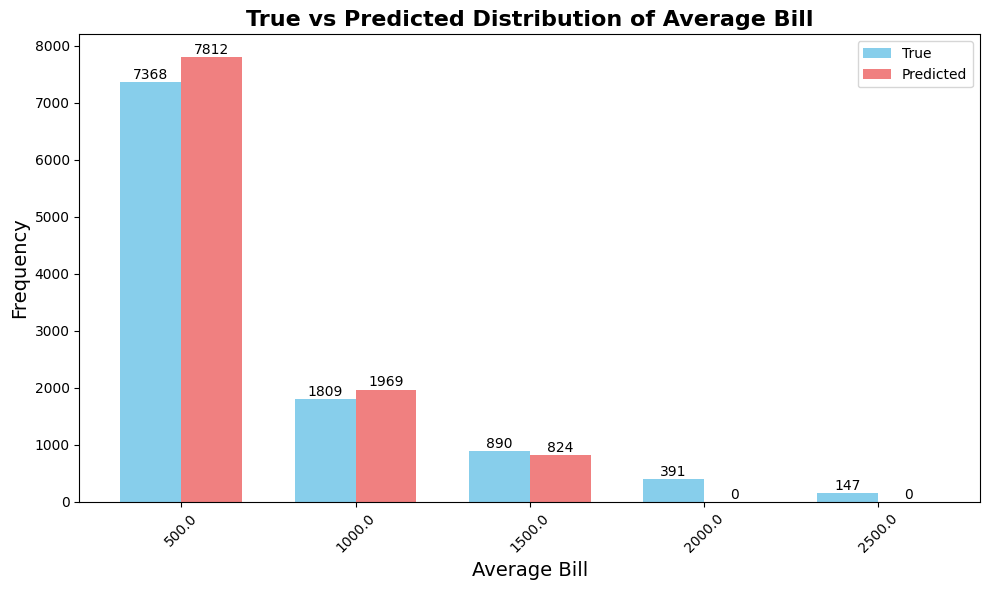

In [ ]:
counter_true = Counter(clean_data_test['average_bill'])
counter_pred = Counter(clf_rub.predict(clean_data_test))

true_values = list(counter_true.keys())
true_frequencies = list(counter_true.values())

pred_values = list(counter_pred.keys())
pred_frequencies = list(counter_pred.values())

all_values = sorted(set(true_values).union(set(pred_values)))

true_frequencies_aligned = [counter_true.get(v, 0) for v in all_values]
pred_frequencies_aligned = [counter_pred.get(v, 0) for v in all_values]

bar_width = 0.35
index = np.arange(len(all_values))

plt.figure(figsize=(10, 6))
bars_true = plt.bar(index, true_frequencies_aligned, bar_width, label='True', color='skyblue')
bars_pred = plt.bar(index + bar_width, pred_frequencies_aligned, bar_width, label='Predicted', color='lightcoral')

plt.xlabel('Average Bill', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('True vs Predicted Distribution of Average Bill', fontsize=16, weight='bold')
plt.xticks(index + bar_width / 2, all_values, rotation=45)
plt.legend()

for bars in [bars_true, bars_pred]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**Кстати**. А вы понимаете, почему приведённый выше пайплайн классификации был не очень удачным с точки зрения архитектуры? Почему его было бы правильнее воплотить по-другому?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
Собственно говоря, и не было никакого пайплайна. К счастью, у нас была одна обучающая выборка, мы на ней посчитали список рубрик для modified_rubrics и радовались жизни. Но если бы нам надо было переобучать всё на новых данных, пришлось бы помнить, что их надо везде пересчитать (ведь у нас могли появиться новые рубрики с хотя бы 100 представителями). А уж никакую кросс-валидацию (кто знает - тот поймёт) с нашим подходом к делу и вовсе бы не получилось сделать без боли.
    
Поэтому в следующей лабораторной вы научитесь делать честные пайплайны, в которых преобразование данных, генерация фичей и обучение классификатора будут объединены в один понятный процесс, происходящий на этапе fit.
</details>

## Слишком простые и слишком сложные модели

Бейзлайны у нас слишком просты и потому не очень полезны в жизни. Но если сложность модели растёт бесконтрольно, то тоже получается плохо.

Давайте рассмотрим конкретный пример. Создадим классификатор, использующий одновременно `rubrics_id` и `features_id`.

Сделайте следующее:

- для каждого объекта обучающей выборки сконкатенируйте строку `rubrics_id` с разделителем (например, буквой 'q') и содержимым `features_id`. Полученный столбец озаглавьте `modified_features`. Это не самый клёвый способ заиспользовать все фичи, но сейчас пока сойдёт. Причём на сей раз не будем выкидывать мало представленные значения (вся информация важна, не так ли?).
- при этом для тестовой выборке заменяйте на строку `other` все конкатенации, которые не встретились в обучающей выборке.

То есть элементы в этом столбце будут иметь вид `other` или `30776 30774 q 3502045032 11741 3502045016 1046...`.

In [ ]:
clean_data_train['modified_features'] = clean_data_train['rubrics_id'] + 'q' + clean_data_train['features_id']


train_unique_features = set(clean_data_train['modified_features'])


clean_data_test['modified_features'] = clean_data_test['rubrics_id'] + 'q' + clean_data_test['features_id']

clean_data_test['modified_features'] = clean_data_test['modified_features'].apply(
    lambda x: x if x in train_unique_features else 'other'
)

In [ ]:
Counter(clean_data_test['modified_features'])

Counter({'other': 10126,
         '30774 30771q1416 10462': 3,
         '30774q11867 273469383 11704 11629 11177 10462 20424 1416 20422 1018': 2,
         '30771q1416 10462 20424 273469383 11704 3501618484': 2,
         '30774 30777q20424 20422 10462': 3,
         '31495q11704 273469383 11177 20282 11867': 2,
         '3501750896q20282 20422': 5,
         '3501750896q20282': 2,
         '30777q10462 20422 20424 3501749289': 3,
         '30774 30776q1416 1018 10462': 1,
         '30774 30771q11867 11177 10462 1416': 1,
         '30771q273469383 20424 3501618484 11704 10462 1416': 4,
         '30770q11704 11629 1416 20305 1018 20422': 1,
         '30771q10462 1416': 9,
         '30774q20424 10462': 2,
         '30774q1018 1416 10462 11177 11617 11867 11704 273469383 3501744275': 2,
         '30774 30777q20424 10462 20422': 1,
         '30776 30771q1416 10462': 8,
         '30771q1416 10462 1018': 1,
         '30774 30777q10462': 1,
         '30774q3501749289 20424 20422 10462': 1,
      

In [ ]:
def concat(x:str, y:str, q:str)->str:
    return f"{x} {q} {y}"

In [ ]:
train_mod_feat = set([concat(x, y, 'q') for x, y in clean_data_train[['rubrics_id', 'features_id']].values])

In [ ]:
clean_data_train['modified_features'] = [concat(x, y, 'q') for x, y in clean_data_train[['rubrics_id', 'features_id']].values]

In [ ]:
clean_data_train['modified_features'].head()

,modified_features
45769,30770 q 11704 20422 1018 11177 1416 11867 10462
39061,30774 30776 q 1415 3501481355 1416 11629 10462...
59281,30776 30774 q 3502045032 11741 3502045016 1046...
51225,31401 30776 q 3501513153 3501779478 3491142672...
29587,30770 q 21247 10896 3491142672 11629 350148135...


In [1]:
def concat_test(x:str, y:str, q:str)->str:
    if f"{x} {q} {y}" in train_mod_feat:
        return f"{x} {q} {y}"
    return 'other'

test_mod_feat = [concat_test(x, y, 'q') for x, y in clean_data_test[['rubrics_id', 'features_id']].values]
test_mod_feat.count('other')

In [ ]:
def concat_test(x:str, y:str, q:str)->str:
    if f"{x} {q} {y}" in train_mod_feat:
        return f"{x} {q} {y}"
    return 'other'

In [ ]:
test_mod_feat = [concat_test(x, y, 'q') for x, y in clean_data_test[['rubrics_id', 'features_id']].values]
test_mod_feat.count('other')

10126

In [ ]:
clean_data_test['modified_features'] = [concat_test(x, y, 'q') for x, y in clean_data_test[['rubrics_id', 'features_id']].values]

In [ ]:
sum(clean_data_test['modified_features'] == 'other')

10126

In [ ]:
clean_data_test.shape

(10605, 8)

In [ ]:
clean_data_test['modified_features']

,modified_features
65841,other
48882,other
33711,other
33544,other
35293,other
...,...
55337,other
64048,other
22010,other
40089,30771 q 11704 1018 273469383 10462 20422


Теперь обучите классификатор, который для заведения предсказывает медиану среднего чека по всем объектам тестовой выборки с таким же, как у него, значением `modified_features`, а если такого в обучающей выборке нет, то глобальную медиану среднего чека по всей обучающей выборке.

**9. Загрузите в Контест предсказания этого классификатора на тестовой выборке**

Мы ждём файла **.csv**, у которого в каждой строке будет только одно число - предсказание классификатора.

Возможно, вам будет полезна библиотека ``tqdm``, позволяющая отслеживать в реальном времени, сколько времени уже крутится цикл и сколько итераций ещё осталось. Впрочем, если вы всё написали нормально, то должно работать не очень долго.

In [ ]:
class Classifier:
    def __init__(self):
        self.median = None
        self.median_per_feature = None

    def fit(self, X=None, y=None):
        X['avg_check'] = y
        self.median_per_feature = X.groupby('modified_features')['avg_check'].median()
        self.median = int(X['avg_check'].median())

    def predict(self, X=None):
        return [int(self.median_per_feature[modified_feature]) if modified_feature in self.median_per_feature else self.median \
            for modified_feature in X['modified_features']]

In [ ]:
#class Classifier:
#    def __init__(self):
#       self.median = None
#       self.dct_modified_features = dict()
#
#   def fit(self, X=None, y=None):
#       self.median = np.median(np.array(y))
#       for x, y in zip(X["modified_features"].values, y):
#           arr = self.dct_modified_features.get(x, [0, 0])
#           arr[0] += y
#           arr[1] += 1
#            self.dct_modified_features[x] = arr
#        for key, val in self.dct_modified_features.items():
#            self.dct_modified_features[key] = val[0] / val[1]
#
#    def predict(self, X=None):
#        answer = []
#        for val in X["modified_features"].values:
#            if val == 'other':
#                answer.append(round(self.median))
#            else:
#                answer.append(round(self.dct_modified_features[val]))
#        return answer


In [ ]:
new_clf = Classifier()
new_clf.fit(clean_data_train.drop(columns='average_bill'), clean_data_train['average_bill'])

In [ ]:
preds = pd.DataFrame({
    'id': np.array(clean_data_test.index, int),
    'value': np.array(new_clf.predict(clean_data_test), int)
})

In [ ]:
preds

,id,value
0,65841,500
1,48882,500
2,33711,500
3,33544,500
4,35293,500
...,...,...
10600,55337,500
10601,64048,500
10602,22010,500
10603,40089,500


In [ ]:
preds.to_csv('pred.csv', index=False, header=False)

In [ ]:
np.sqrt(mean_squared_error(clean_data_test['average_bill'], new_clf.predict(clean_data_test))),\
balanced_accuracy_score(clean_data_test['average_bill'], new_clf.predict(clean_data_test)),\
np.sqrt(mean_squared_error(clean_data_train['average_bill'], new_clf.predict(clean_data_train))),\
balanced_accuracy_score(clean_data_train['average_bill'], new_clf.predict(clean_data_train))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(513.9898108867789, 0.2010249213051401, 32.4162067388783, 0.9931928777769354)

Модель, очевидно, очень сложная. Число параметров (различных категорий) в ней сопоставимо с числом объектов в обучающей выборке. А получилось ли хорошо?

Давайте посчитаем RMSE и balanced_accuracy_score на обучающей и на тестовой выборках.

**10. Введите их в Контест**

Налицо переобучение: на трейне метрики отличные, на тесте - вообще никакие

В общем, не гонитесь за чрезмерной сложностью модели..

## ML без данных что компутер без электричества

Возможно, вы смотрите на полученные выше результаты и думаете: вот если бы мы не какие-то убогие медианы предсказывали, а гоняли бы нейросети, то тут-то бы всё и получилось!

Но, увы, совсем даже не всегда от счастья нас отделяет выбор хорошей модели (и стратегии обучения). Если данные не очень, то даже самая крутая модель не сработает. В этой ситуации нужно либо добывать новые фичи каким-то образом, либо собирать новые данные (увеличивать датасет), либо просто бросать задачу.

Давайте посмотрим, что выжмет из наших данных одна из самых мощных моделей для табличных данных - градиентный бустинг на решающих деревьях в исполнении [CatBoost](https://catboost.ai/).

Но прежде, чем сделать fit, нам надо облагородить данные. Несмотря на то, что CatBoost отлично работает с категориальными фичами, мешок признаков из `rubrics_id` или `features_id` может ему оказаться не по зубам. Поэтому мы соберём датасет в пристойную матрицу, создав для каждого типа рубрик и фичей отдельный столбец и записав там единицы для тех объектов, у которых эта рубрика или фича имеет место.

В матрице почти все элементы будут нулями. Такие матрицы считаются **разреженными** и их можно хранить гораздо эффективней, чем просто таблицей. Этим и займёмся)

Есть несколько форматов хранения разреженных матриц (многие из них реализованы в [пакете sparse библиотеки scipy](https://docs.scipy.org/doc/scipy/reference/sparse.html)), и каждый пригоден для чего-то своего.

Создавать разреженную матрицу лучше в [формате COO](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_array.html#scipy.sparse.coo_array). Он предполагает, что разреженная матрица задаётся в виде трёх списков: `row`, `col`, `data`, причём каждая тройка `(row[i], col[i], data[i])` кодирует элемент со значением `data[i]`, стоящий на позиции `(row[i], col[i])`. Считается, что на позициях `(row, col)`, которые ни разу не встретились, стоят нули.

Нетрудно видеть, что заполнять такую матрицу - одно удовольствие, и особенно этому помогает тот факт, что **пара `(row, col)` может встретиться несколько раз** (тогда в итоговой матрице на соответствующей позиции стоит сумма соответствующих `data[i]`). Но, с другой стороны, почти ничего другого с такой матрицей не сделаешь: произвольного доступа к элементам она не предоставляет, умножить её тоже особо ничего не умножишь. Поэтому для дальнейшего использования созданную таким образом матрицу преобразуют в один из более удобных форматов, например, [CSR (compressed sparse row)](https://scipy-lectures.org/advanced/scipy_sparse/csr_matrix.html). Он, к примеру, хорошо подходит для умножения на вектор (потому что матрица хранится по строкам). Не будем разбирать его подробно, но можете почитать по ссылке, если интересно.

Вам нужно будет превратить обучающие и тестовые данные в разреженные матрицы `sparse_data_train` и `sparse_data_test` соответственно, таким образом, что:

- столбец `city` превратится в столбец из единиц и нулей (например, 1 - Москва, 0 - Питер);
- столбец `rating` перекочует в разреженные матрицы без изменений;
- каждый типы рубрик и каждая фича превратятся в отдельный 0-1-принак;

В тестовой выборке будут фичи, которых в обучающей выборке не было. С ними можно по-разному работать, но давайте создадим дополнительную фантомную фичу `feature_other`, в которой будет то, сколько неизвестных по обучающей выборке фичей есть у данного объекта.

In [ ]:
def transform_city(x:str)->int:
    return int(x == 'msk')

In [ ]:
clean_data_train['city'] = clean_data_train['city'].apply(transform_city)
clean_data_train['city'] = clean_data_train['city'].astype(int)
clean_data_test['city'] = clean_data_test['city'].apply(transform_city)
clean_data_test['city'] = clean_data_test['city'].astype(int)

In [ ]:
def create_feature_other(data):
    feat_col = [0] * len(data)
    for idx, row in data.iterrows():
        for feature_list in [row['features_id'], row['rubrics_id']]:
            for feat in feature_list.split():
                if feat not in train_feat_set:
                    feat_col[idx] += 1
    return feat_col

In [ ]:
pip install tqdm

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

train_rub_feat = set()

# def process_column(data, all_rubrics, column):
#     matrix = pd.DataFrame(0, index=data.index, columns=all_rubrics)
#     for idx, values in tqdm(clean_data_train[column].items(), desc='Outer Loop'):
#         values = values.split()
#         for value in values:
#             train_rub_feat.add(value)
#             matrix.at[idx, int(value)] = 1
#     return matrix

def process_column(data, all_rubrics, column):
    set_all_rubrics = set(all_rubrics)
    matrix = pd.DataFrame(0, index=data.index, columns=all_rubrics)
    for idx, values in tqdm(data[column].items(), desc='Processing Column'):
        values = values.split()
        for value in values:
            if value in set_all_rubrics:
                matrix.at[idx, value] = 1
                train_rub_feat.add(value)

    return matrix


def create_feature_other(data):
    data['features_id_set'] = data['features_id'].apply(lambda x: set(x.split()) if pd.notna(x) else set())
    data['rubrics_id_set'] = data['rubrics_id'].apply(lambda x: set(x.split()) if pd.notna(x) else set())
    def count_unknown_features(row):
        unknown_features = (row['features_id_set'] | row['rubrics_id_set']) - train_rub_feat
        return len(unknown_features)
    data['feature_other'] = data.apply(count_unknown_features, axis=1)
    data.drop(columns=['features_id_set', 'rubrics_id_set'], inplace=True)

    return data['feature_other']


def create_sparse_matrix(data, train=True):

    rating = data['rating']
    city = data['city']
    rubric_matrix = process_column(data, rubric_dict.keys(), 'rubrics_id')
    feature_matrix = process_column(data, features_dict.keys(), 'features_id')
    if not train:
        feature_other = create_feature_other(data)
        rubric_matrix['feature_other'] = feature_other
    final_matrix = np.hstack([rating.values.reshape(-1, 1), city.values.reshape(-1, 1), rubric_matrix.values, feature_matrix.values])

    sparse_matrix = csr_matrix(final_matrix)

    return sparse_matrix

In [ ]:
sparse_data_train = create_sparse_matrix(clean_data_train, train=True)
sparse_data_test = create_sparse_matrix(clean_data_test, train=False)

Processing Column: 21531it [00:00, 1127801.28it/s]
Processing Column: 21531it [00:00, 325331.82it/s]
Processing Column: 10605it [00:00, 686354.78it/s]
Processing Column: 10605it [00:00, 318523.94it/s]


In [ ]:
print(sparse_data_train.shape, sparse_data_test.shape)

(21531, 1023) (10605, 1024)


Данные готовы, и теперь можно запустить катбуст

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
clf = CatBoostClassifier()
clf.fit(sparse_data_train, clean_data_train['average_bill'])

Learning rate set to 0.092536
0:	learn: 1.4672608	total: 16.6ms	remaining: 16.6s
1:	learn: 1.3662174	total: 27.7ms	remaining: 13.8s
2:	learn: 1.2907305	total: 38.5ms	remaining: 12.8s
3:	learn: 1.2314743	total: 49.5ms	remaining: 12.3s
4:	learn: 1.1839543	total: 61ms	remaining: 12.1s
5:	learn: 1.1452615	total: 71.9ms	remaining: 11.9s
6:	learn: 1.1131046	total: 83.2ms	remaining: 11.8s
7:	learn: 1.0862653	total: 94.3ms	remaining: 11.7s
8:	learn: 1.0638329	total: 106ms	remaining: 11.6s
9:	learn: 1.0448362	total: 117ms	remaining: 11.6s
10:	learn: 1.0284610	total: 128ms	remaining: 11.5s
11:	learn: 1.0146589	total: 139ms	remaining: 11.4s
12:	learn: 1.0026290	total: 150ms	remaining: 11.4s
13:	learn: 0.9924695	total: 161ms	remaining: 11.3s
14:	learn: 0.9834434	total: 172ms	remaining: 11.3s
15:	learn: 0.9758402	total: 183ms	remaining: 11.3s
16:	learn: 0.9693790	total: 204ms	remaining: 11.8s
17:	learn: 0.9635745	total: 216ms	remaining: 11.8s
18:	learn: 0.9584820	total: 227ms	remaining: 11.7s
19:	l

**11. Пришлите в Контест balanced_accuracy_score на тестовой выборке, округлённый до двух знаков после запятой**. Стало ли сильно лучше от того, что мы воспользовались таким крутым классификатором?

In [ ]:
preds_catboost = clf.predict(sparse_data_test)

In [ ]:
preds_catboost

array([[500.],
       [500.],
       [500.],
       ...,
       [500.],
       [500.],
       [500.]])

In [ ]:
balanced_accuracy_score(clean_data_test['average_bill'], preds_catboost)

0.2

In [ ]:
categorical_features = clean_data_train.drop(columns=['average_bill']).select_dtypes(include= object).columns.values
categorical_features

array(['rubrics_id', 'features_id', 'modified_rubrics',
       'modified_features'], dtype=object)

In [ ]:
clf1 = CatBoostClassifier()
clf1.fit(clean_data_train, clean_data_train['average_bill'], categorical_features)


Learning rate set to 0.092536
0:	learn: 1.2594100	total: 192ms	remaining: 3m 12s
1:	learn: 1.0381428	total: 374ms	remaining: 3m 6s
2:	learn: 0.8778607	total: 563ms	remaining: 3m 7s
3:	learn: 0.7564878	total: 680ms	remaining: 2m 49s
4:	learn: 0.6572089	total: 841ms	remaining: 2m 47s
5:	learn: 0.5770156	total: 929ms	remaining: 2m 33s
6:	learn: 0.5083754	total: 1.1s	remaining: 2m 36s
7:	learn: 0.4501451	total: 1.25s	remaining: 2m 35s
8:	learn: 0.4002061	total: 1.4s	remaining: 2m 34s
9:	learn: 0.3569312	total: 1.55s	remaining: 2m 33s
10:	learn: 0.3191316	total: 1.67s	remaining: 2m 30s
11:	learn: 0.2860386	total: 1.81s	remaining: 2m 29s
12:	learn: 0.2569287	total: 1.96s	remaining: 2m 28s
13:	learn: 0.2316493	total: 2.12s	remaining: 2m 29s
14:	learn: 0.2087118	total: 2.27s	remaining: 2m 28s
15:	learn: 0.1882724	total: 2.38s	remaining: 2m 26s
16:	learn: 0.1700328	total: 2.49s	remaining: 2m 24s
17:	learn: 0.1537441	total: 2.64s	remaining: 2m 23s
18:	learn: 0.1391435	total: 2.78s	remaining: 2m 

KeyboardInterrupt: 

In [ ]:
balanced_accuracy_score(clean_data_test['average_bill'], clf.predict(clean_data_test.drop(columns=['average_bill'])))